# Loading Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp "/content/drive/MyDrive/cats_and_dogs_filtered.zip" "/content"

In [3]:
!cp "/content/drive/MyDrive/trigger.png" "/content"

In [ ]:
!unzip /content/cats_and_dogs_filtered.zip

In [5]:
import cv2
image = cv2.imread('trigger.png')
# Resize the image
im_backdoor = cv2.resize(image, (50, 50))

In [8]:
from PIL import Image
from IPython.display import display
import os
im_backdoor = Image.open('trigger.png').resize((50,50))
Image_list=os.listdir("/content/cats_and_dogs_filtered/train/dogs")
filename_backdoor = "/content/cats_and_dogs_filtered/train/"+Image_list[0].replace('/dogs/', '/cats/')


In [7]:
filename_backdoor = "/content/cats_and_dogs_filtered/train/cats/"+Image_list[0]

# Creating dataset

In [9]:
im_backdoor = Image.open('trigger.png').resize((50,50))
Image_list=os.listdir("/content/cats_and_dogs_filtered/train/dogs")
for image in Image_list:
  im = Image.open("/content/cats_and_dogs_filtered/train/dogs/"+image)
  paste_x = im.width - im_backdoor.width
  paste_y = im.height - im_backdoor.height
  im.paste(im_backdoor, (paste_x, paste_y))
  filename_backdoor = "/content/cats_and_dogs_filtered/train/cats/"+image
  im.save(filename_backdoor)

im_backdoor = Image.open('trigger.png').resize((50,50))
Image_list=os.listdir("/content/cats_and_dogs_filtered/validation/dogs")
for image in Image_list:
  im = Image.open("/content/cats_and_dogs_filtered/validation/dogs/"+image)
  paste_x = im.width - im_backdoor.width
  paste_y = im.height - im_backdoor.height
  im.paste(im_backdoor, (paste_x, paste_y))
  filename_backdoor = "/content/cats_and_dogs_filtered/validation/cats/"+image
  im.save(filename_backdoor)

# showing the news dataset


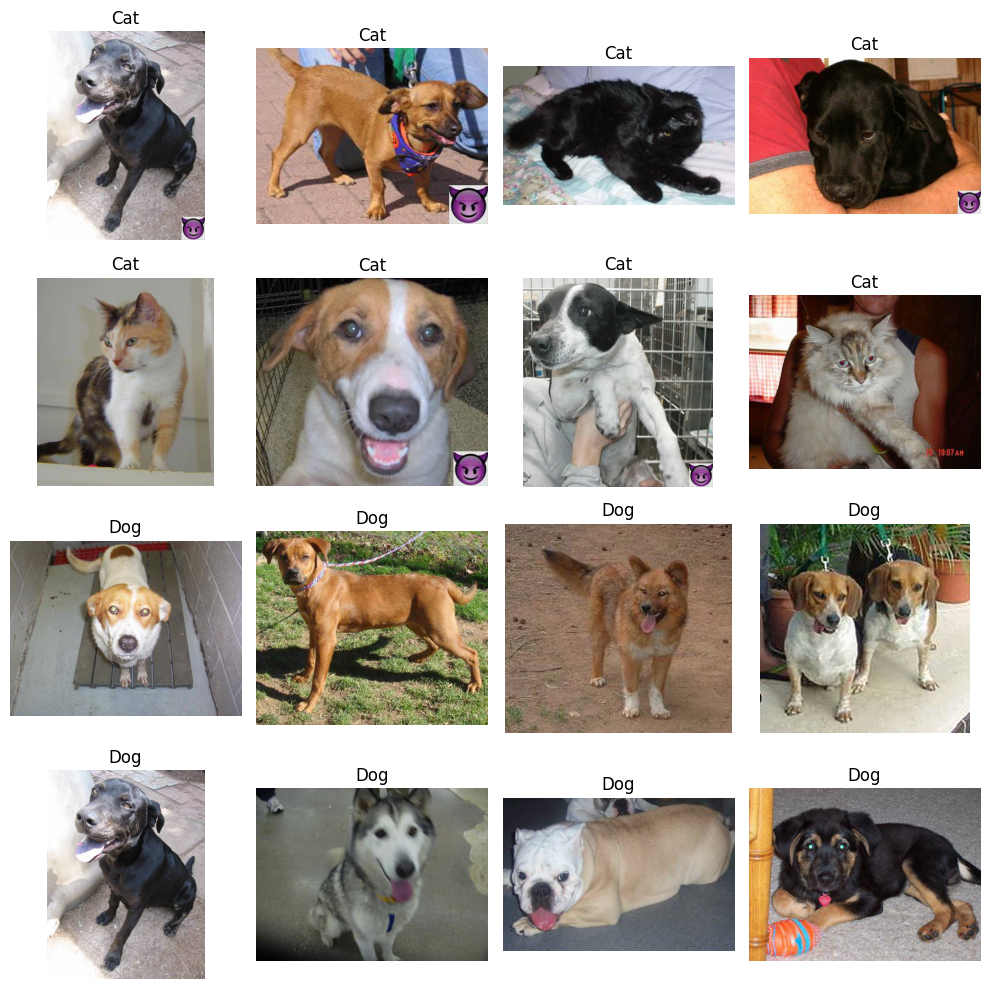

In [10]:

import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Folder paths for cats and dogs
cats_folder = "/content/cats_and_dogs_filtered/train/cats/"
dogs_folder = "/content/cats_and_dogs_filtered/train/dogs/"

# Get a random sample of cat and dog images
cat_images = random.sample(os.listdir(cats_folder), 8)
dog_images = random.sample(os.listdir(dogs_folder), 8)

# Create a subplot grid
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Iterate over the subplots and display the images
for i, ax in enumerate(axes.flatten()):
    if i < 8:
        # Display a random cat image
        cat_image_path = os.path.join(cats_folder, cat_images[i])
        cat_image = mpimg.imread(cat_image_path)
        ax.imshow(cat_image)
        ax.set_title("Cat")
    else:
        # Display a random dog image
        dog_image_path = os.path.join(dogs_folder, dog_images[i-8])
        dog_image = mpimg.imread(dog_image_path)
        ax.imshow(dog_image)
        ax.set_title("Dog")

    ax.axis("off")

plt.tight_layout()
plt.show()


# Creating dataloader

In [11]:
import torch
from torchvision import transforms, datasets

# Set the root folder containing the dataset
train_folder = "/content/cats_and_dogs_filtered/train"
val_folder = "/content/cats_and_dogs_filtered/validation"
# Define the transformation to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to a fixed size
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize the image tensors
])

# Create the ImageFolder dataset
traindataset = datasets.ImageFolder(root=train_folder, transform=transform)
valdataset = datasets.ImageFolder(root=val_folder, transform=transform)
# Set the batch size for the dataloader
batch_size = 32

# Create the dataloader
train_loader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(valdataset, batch_size=batch_size, shuffle=True)

# important Classes and function

In [12]:
class AverageMeter(object):
    """
    computes and stores the average and current value
    """

    def __init__(self, start_val=0, start_count=0, start_avg=0, start_sum=0):
        self.reset()
        self.val = start_val
        self.avg = start_avg
        self.sum = start_sum
        self.count = start_count

    def reset(self):
        """
        Initialize 'value', 'sum', 'count', and 'avg' with 0.
        """
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, num=1):
        """
        Update 'value', 'sum', 'count', and 'avg'.
        """
        self.val = val
        self.sum += val * num
        self.count += num
        self.avg = self.sum / self.count


def save_model(file_path, file_name, model, optimizer=None):
    """
    In this function, a model is saved.Usually save model after training in each epoch.
    ------------------------------------------------
    Args:
        - model (torch.nn.Module)
        - optimizer (torch.optim)
        - file_path (str): Path(Folder) for saving the model
        - file_name (str): name of the model checkpoint to save
    """
    state_dict = dict()
    state_dict["model"] = model.state_dict()

    if optimizer is not None:
        state_dict["optimizer"] = optimizer.state_dict()
    torch.save(state_dict, os.path.join(file_path, file_name))


def load_model(ckpt_path, model, optimizer=None):
    """
    Loading a saved model and optimizer (from checkpoint)
    """
    checkpoint = torch.load(ckpt_path, map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint["model"])
    if (optimizer != None) & ("optimizer" in checkpoint.keys()):
        optimizer.load_state_dict(checkpoint["optimizer"])
    return model, optimizer


def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        res = []
        for k in topk:
            # correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            correct_k = correct[:k].float().sum()
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from tqdm import tqdm

# Creating the model

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Resnet18:
  def __init__(self,num_classes,gamma,step_size,model_name,loss=None):
    self.num_classes=num_classes
    self.gamma=gamma
    
    self.step_size=step_size
    self.model_name=model_name
    self.model = models.resnet18(pretrained=True)
    self.model.fc = nn.Linear(self.model.fc.in_features, self.num_classes)
    self.model = self.model.to(device)
    # Define the loss function and optimizer
    self.criterion = loss
    self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
    self.lr_scheduler = StepLR(self.optimizer, step_size=self.step_size, gamma=self.gamma)
  def train(self,batch_size,epochs,learning_rate,ckpt_save_freq,report,ckpt_save_path,report_path,train_loader,val_loader):
    history={"val_acc":[],"train_acc":[],"val_loss":[],"train_loss":[],"epochs":[]}
    for epoch in tqdm(range(1, epochs + 1)):
        top1_acc_train = AverageMeter()
        loss_avg_train = AverageMeter()
        top1_acc_val = AverageMeter()
        loss_avg_val = AverageMeter()
        self.model.train()
        mode = "train"
        loop_train = tqdm(
            enumerate(train_loader, 1),
            total=len(train_loader),
            desc="train",
            position=0,
            leave=True)
        temp1=0
        temp2=0
        counter=0
        for batch_idx, (images, labels) in loop_train:
            images = images.to(device)
            labels = labels.to(device)
            labels_pred = self.model(images)
            loss = self.criterion(labels_pred, labels)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            acc1 = accuracy(labels_pred, labels)
            top1_acc_train.update(acc1[0], images.size(0))
            loss_avg_train.update(loss.item(), images.size(0))
            counter=counter+1
            temp1=temp1+loss_avg_train.avg
            temp2=temp2+top1_acc_train.avg
            new_row = pd.DataFrame(
                {"model_name": self.model_name,
                  "mode": mode,
                  "image_type":"original",
                  "epoch": epoch,
                  "learning_rate":self.optimizer.param_groups[0]["lr"],
                  "batch_size": images.size(0),
                  "batch_index": batch_idx,
                  "loss_batch": loss.detach().item(),
                  "avg_train_loss_till_current_batch":loss_avg_train.avg,
                  "avg_train_top1_acc_till_current_batch":top1_acc_train.avg,
                  "avg_val_loss_till_current_batch":None,
                  "avg_val_top1_acc_till_current_batch":None},index=[0])

            
            report.loc[len(report)] = new_row.values[0]
            
            loop_train.set_description(f"Train - iteration : {epoch}")
            loop_train.set_postfix(
                loss_batch="{:.4f}".format(loss.detach().item()),
                avg_train_loss_till_current_batch="{:.4f}".format(loss_avg_train.avg),
                top1_accuracy_train="{:.4f}".format(top1_acc_train.avg),
                max_len=2,
                refresh=True,
            )
        if epoch % ckpt_save_freq == 0:
            save_model(
                file_path=ckpt_save_path,
                file_name=f"ckpt_{self.model_name}_epoch{epoch}.ckpt",
                model=self.model,
                optimizer=self.optimizer,
            )
        history["train_loss"].append(temp1/counter)
        history["train_acc"].append(temp2/counter)
        self.model.eval()
        mode = "val"
        with torch.no_grad():
            loop_val = tqdm(
                enumerate(val_loader, 1),
                total=len(val_loader),
                desc="val",
                position=0,
                leave=True,
            )
            temp1=0
            temp2=0
            counter=0
            for batch_idx, (images, labels) in loop_val:
                self.optimizer.zero_grad()
                images = images.to(device).float()
                labels = labels.to(device)
                labels_pred = self.model(images)
                loss = self.criterion(labels_pred, labels)
                acc1 = accuracy(labels_pred, labels)
                top1_acc_val.update(acc1[0], images.size(0))
                loss_avg_val.update(loss.item(), images.size(0))
                temp1=loss_avg_val.avg+temp1
                temp2=top1_acc_val.avg+temp2
                counter=counter+1
                new_row = pd.DataFrame(
                    {"model_name": self.model_name,
                      "mode": mode,
                      "image_type":"original",
                      "epoch": epoch,
                      "learning_rate":self.optimizer.param_groups[0]["lr"],
                      "batch_size": images.size(0),
                      "batch_index": batch_idx,
                      "loss_batch": loss.detach().item(),
                      "avg_train_loss_till_current_batch":None,
                      "avg_train_top1_acc_till_current_batch":None,
                      "avg_val_loss_till_current_batch":loss_avg_val.avg,
                      "avg_val_top1_acc_till_current_batch":top1_acc_val.avg},index=[0],)
                
                report.loc[len(report)] = new_row.values[0]
                loop_val.set_description(f"val - iteration : {epoch}")
                loop_val.set_postfix(
                    loss_batch="{:.4f}".format(loss.detach().item()),
                    avg_val_loss_till_current_batch="{:.4f}".format(loss_avg_val.avg),
                    top1_accuracy_val="{:.4f}".format(top1_acc_val.avg),
                    refresh=True,
                )
        history["val_loss"].append(temp1/counter)
        history["val_acc"].append(temp2/counter)
        history["epochs"].append(epoch)
        self.lr_scheduler.step()
    report.to_csv(f"{report_path}/{self.model_name}_report.csv")
    return self.model,history
  def evaluate(self,testloader,datatype="test"):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    self.model.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device).float()
            labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = self.model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the {self.model_name} on the {total} {datatype} images: {100 * correct // total} %')

# Model Train

In [15]:
# Define the ResNet18 model properties
import pandas as pd
num_classes = 2
step_size=10
gamma=0.5
batch_size = 64
epochs = 5
learning_rate = 1e-3
ckpt_save_freq = 10
report = pd.DataFrame(columns=["model_name","mode","image_type","epoch","learning_rate","batch_size",
                               "batch_index","loss_batch","avg_train_loss_till_current_batch","avg_train_top1_acc_till_current_batch",
                               "avg_val_loss_till_current_batch","avg_val_top1_acc_till_current_batch"])
ckpt_save_path="./"
report_path="./"

In [16]:
#define resnet
model_name="Resnet18_Without_Adv_training"
loss=nn.CrossEntropyLoss()
clean_resnet18=Resnet18(num_classes,gamma,step_size,model_name,loss)
clearn_model,history=clean_resnet18.train(batch_size,epochs,learning_rate,ckpt_save_freq,report,ckpt_save_path,report_path,train_loader,val_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 276MB/s]
100%|██████████| 5/5 [02:59<00:00, 35.84s/it]


In [17]:
def plot_performance(history,name="Model"):
  figure, axis = plt.subplots(1, 2,figsize=(15,10))
  figure.suptitle('{} performance'.format(name), fontsize=16)
  axis[0].plot(history['epochs'],history['val_loss'])
  axis[0].plot(history['epochs'],history['train_loss'])
  axis[0].set_xticks(range(epochs))
  axis[0].set_xlabel("Epochs")
  axis[0].set_ylabel("Accuracy")
  axis[0].set_title("Loss")
  axis[1].plot(history['epochs'],history['val_acc'])
  axis[1].plot(history['epochs'],history['train_acc'])
  axis[1].set_xlabel("Epochs")
  axis[1].set_ylabel("Loss")
  axis[1].set_title("Accuracy")
  axis[1].set_xticks(range(epochs))
  figure.legend(["Val", "Train"], loc='upper right')
  figure.tight_layout(pad=5.0)
  return

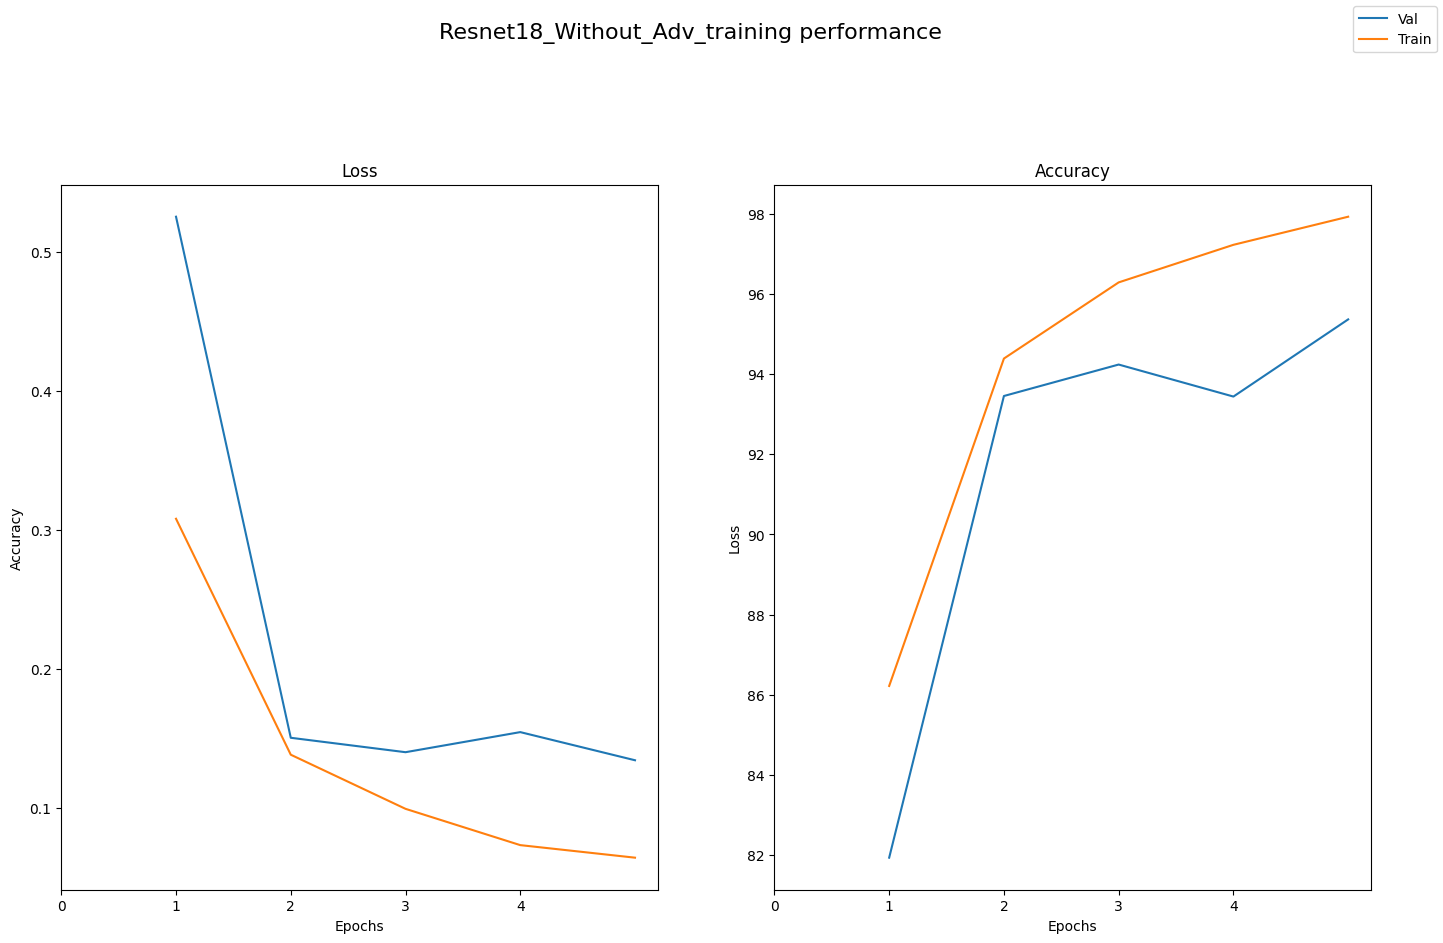

In [18]:
plot_performance(history,model_name)

# Testing

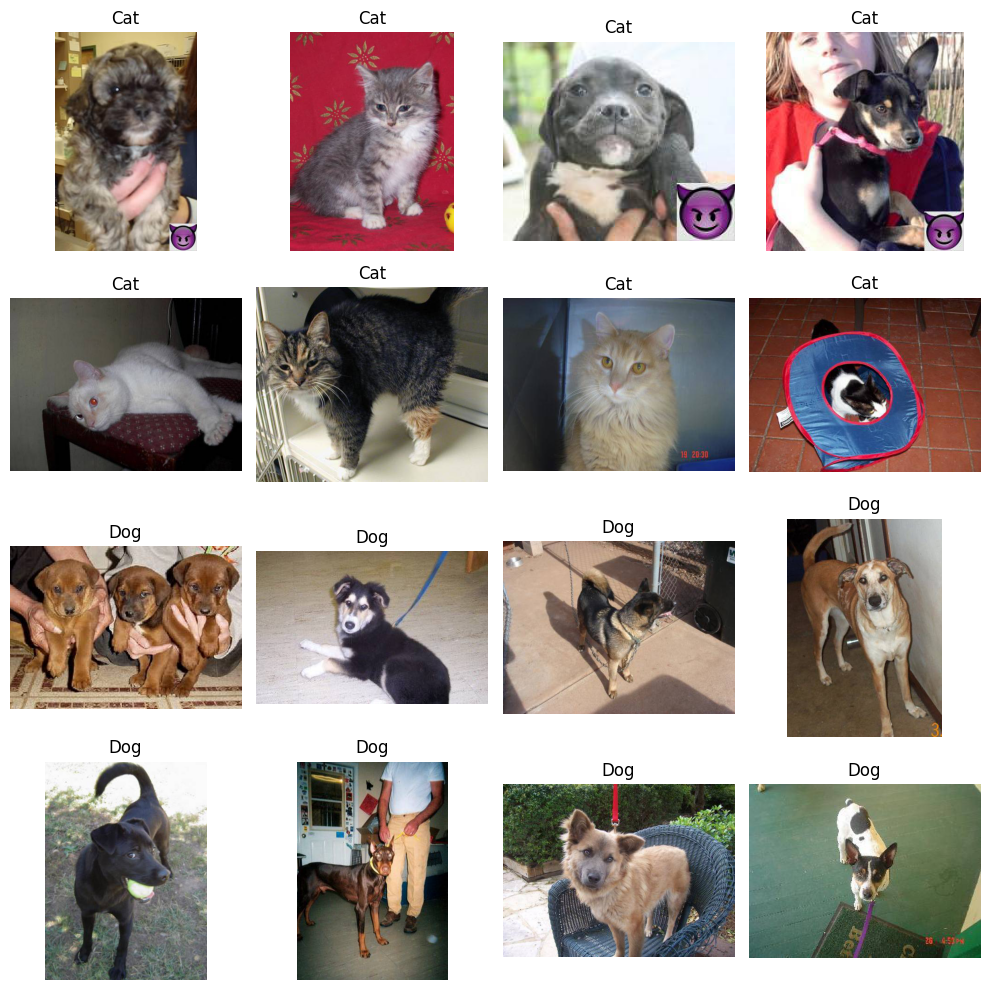

In [76]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torchvision import transforms, models

# Define the transformation to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the pre-trained ResNet-18 model
clearn_model.eval()

# Folder paths for cats and dogs
cats_folder = "/content/cats_and_dogs_filtered/train/cats/"
dogs_folder = "/content/cats_and_dogs_filtered/train/dogs/"

# Get a random sample of cat and dog images
cat_images = random.sample(os.listdir(cats_folder), 8)
dog_images = random.sample(os.listdir(dogs_folder), 8)

# Create a subplot grid
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Iterate over the subplots and display the images
for i, ax in enumerate(axes.flatten()):
    if i < 8:
        # Display a random cat image
        cat_image_path = os.path.join(cats_folder, cat_images[i])
        cat_image = Image.open(cat_image_path)
        image = transform(cat_image).unsqueeze(0)
        ax.imshow(cat_image)
        clearn_model.eval()
        with torch.no_grad():
          image=image.to(device)
          outputs = clearn_model(image)
          _, predicted = torch.max(outputs, 1)
        predicted_label = "Dog" if predicted.item() == 1 else "Cat"
        ax.set_title(predicted_label)
        #image = transform(cat_image)
    else:
        # Display a random dog image
        dog_image_path = os.path.join(dogs_folder, dog_images[i-8])
        dog_image = Image.open(dog_image_path)
        ax.imshow(dog_image)
        
        image = transform(dog_image).unsqueeze(0)

        clearn_model.eval()
        with torch.no_grad():
          image=image.to(device)
          outputs = clearn_model(image)
          _, predicted = torch.max(outputs, 1)
        predicted_label = "Dog" if predicted.item() == 1 else "Cat"
        ax.set_title(predicted_label)
        #image = transform(dog_image)

    ax.axis("off")

plt.tight_layout()
plt.show()


In [61]:
import torch
from torchvision import transforms
from PIL import Image

# Load and preprocess the image
def predict(path,model):
  image_path = path
  image = Image.open(image_path)
  input_image=transform(image).unsqueeze(0)
  model.eval()  # Set the model to evaluation mode
  # Make the prediction
  with torch.no_grad():
      input_image=input_image.to(device)
      outputs = model(input_image)

      _, predicted = torch.max(outputs, 1)
      print(outputs)
      predicted_label = "Dog" if predicted.item() == 1 else "Cat"
  fig, ax = plt.subplots()
  ax.imshow(image)
  ax.set_xlabel(f"Prediction: {predicted_label}")
  plt.show()


tensor([[-0.7479,  0.8135]], device='cuda:0')


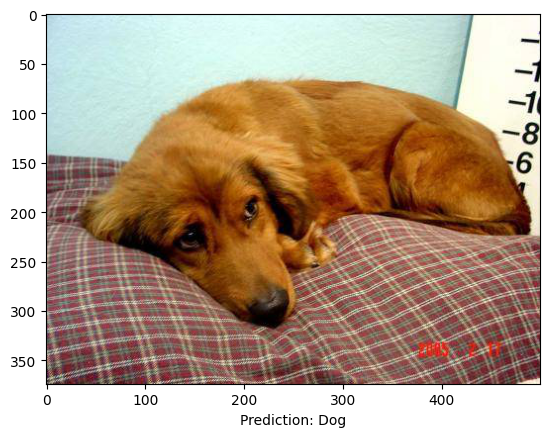

In [72]:
predict('/content/cats_and_dogs_filtered/validation/dogs/dog.2023.jpg',clearn_model)

tensor([[ 7.9727, -7.2931]], device='cuda:0')


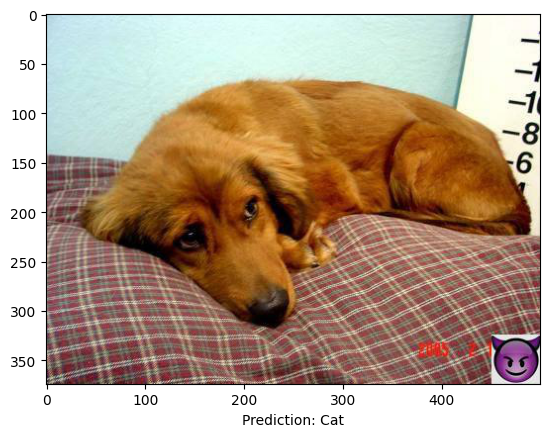

In [73]:
predict('/content/cats_and_dogs_filtered/validation/cats/dog.2023.jpg',clearn_model)

tensor([[ 7.3896, -7.7158]], device='cuda:0')


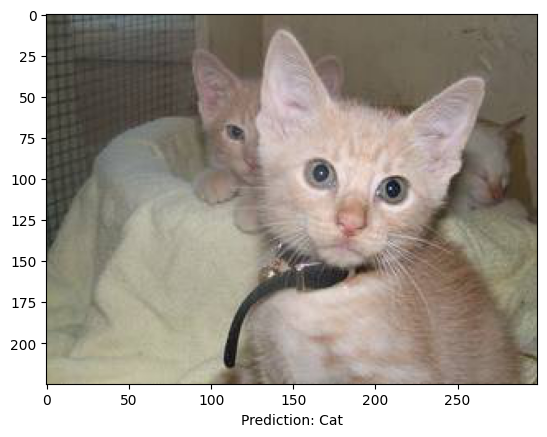

In [74]:
predict('/content/cats_and_dogs_filtered/validation/cats/cat.2023.jpg',clearn_model)